In [34]:
import pandas as pd
import numpy as np
import os
import sys
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [36]:
df_test = pd.read_csv('test.csv')
df_test.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5


DATA EXPLORATION

In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


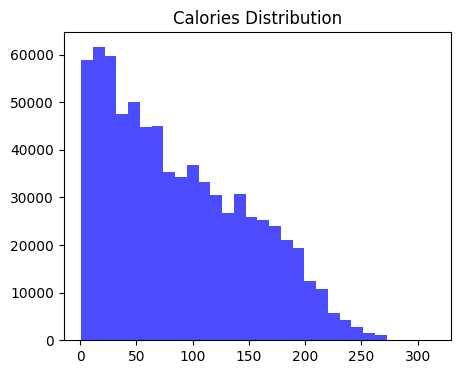

In [38]:
plt.figure(figsize=(5, 4))
plt.hist(df_train['Calories'], bins=30, color='blue', alpha=0.7)
plt.title('Calories Distribution')
plt.show()

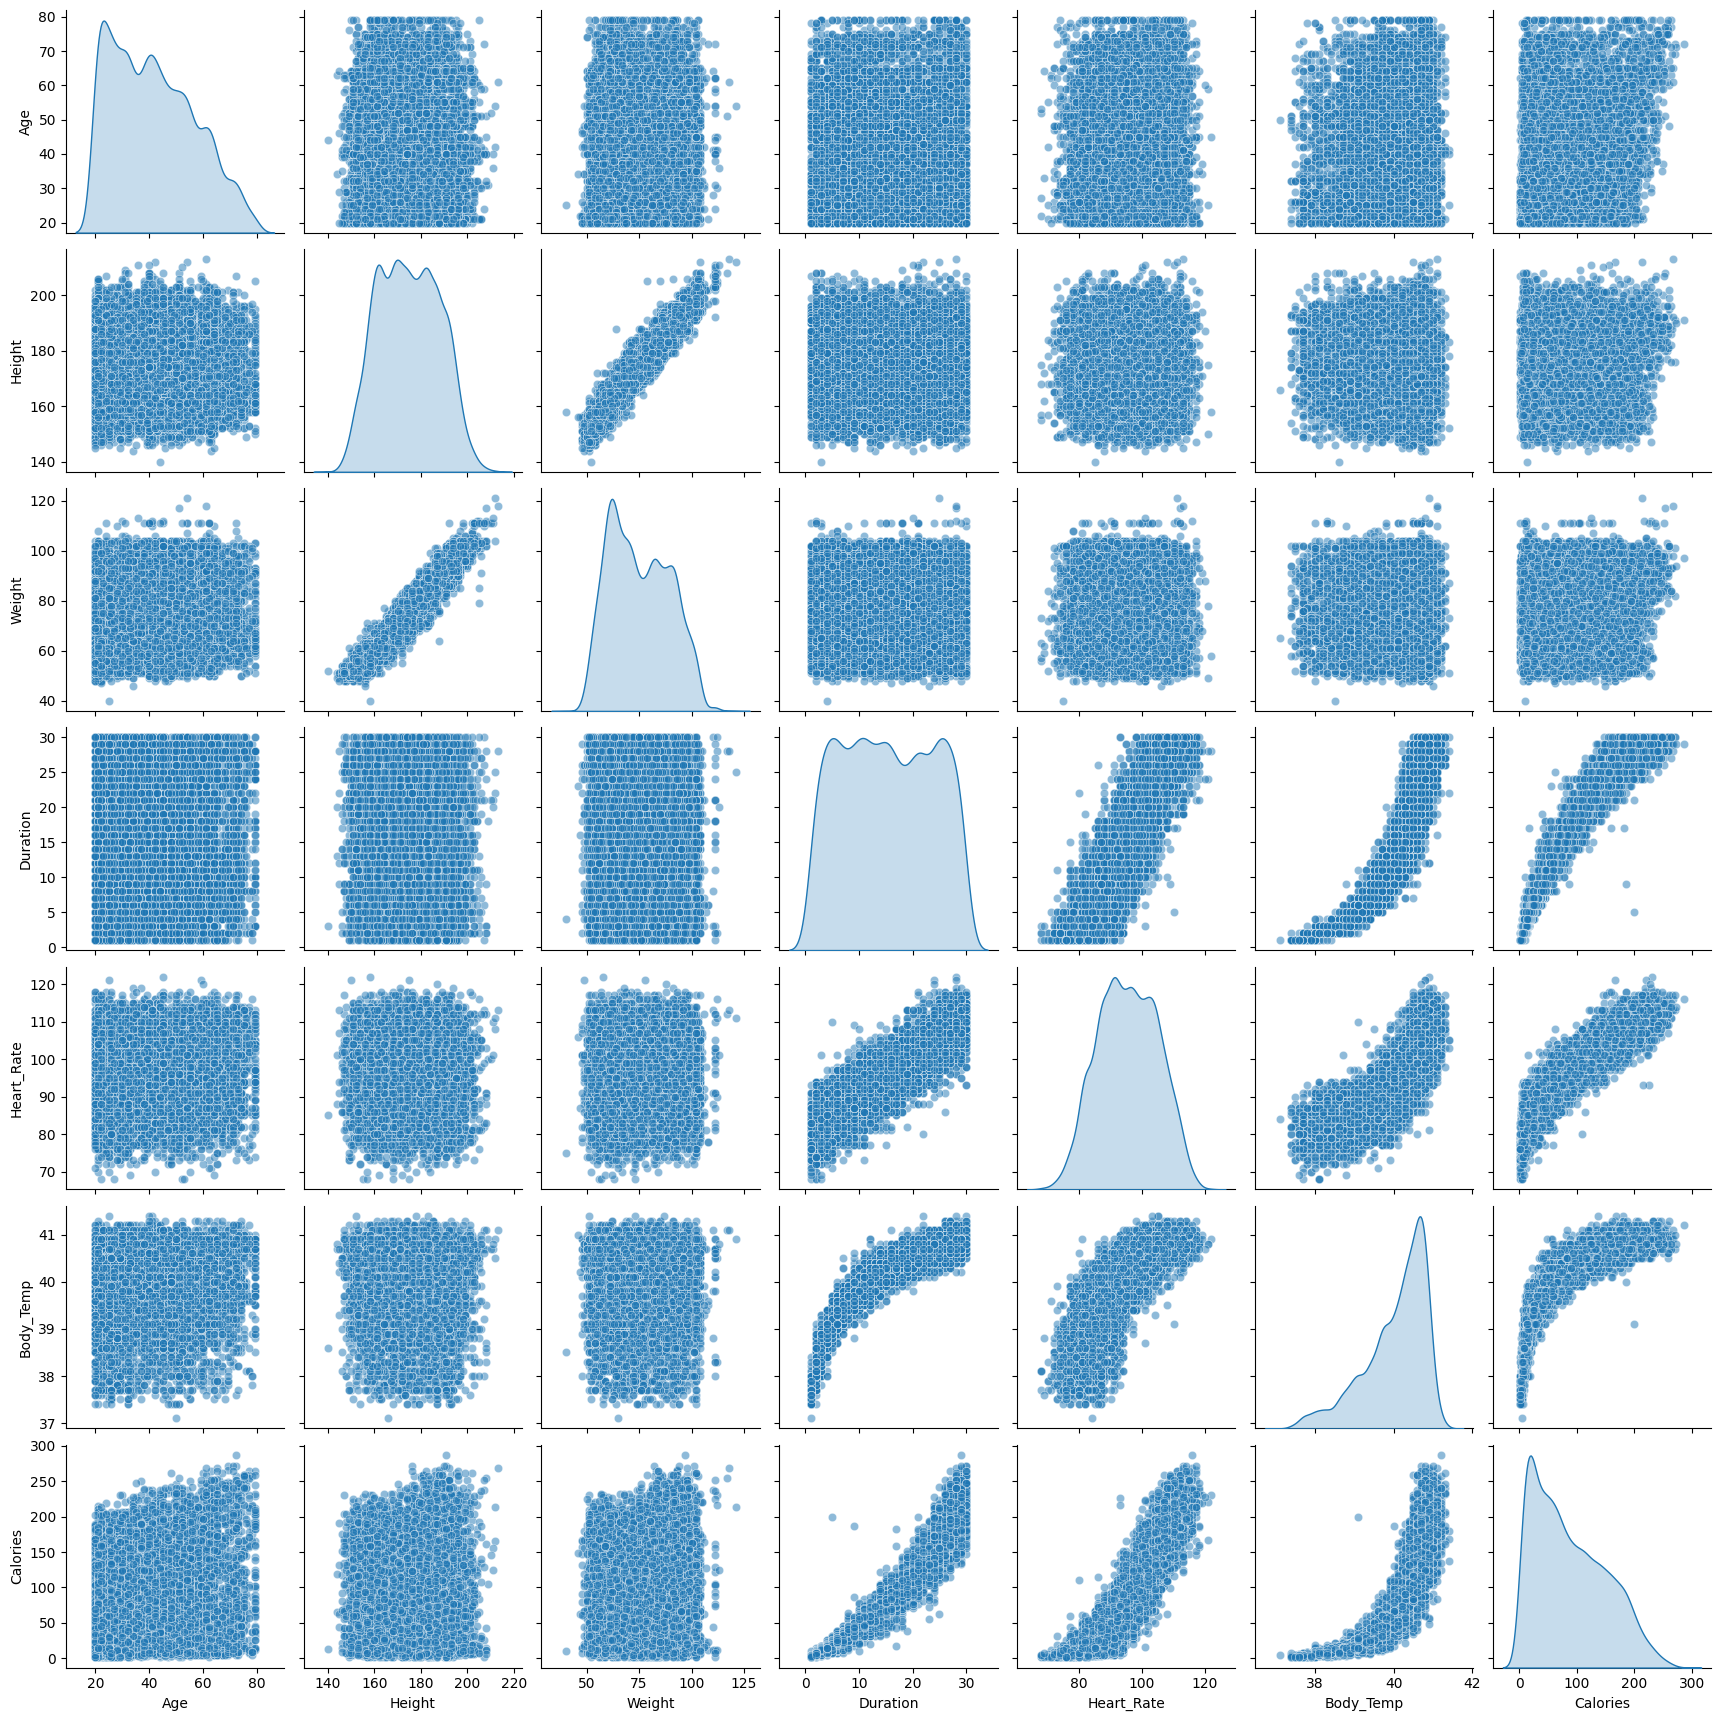

In [39]:
# Generate Scatterplot Matrix
df_sampled = df_train.sample(n=10000, random_state=42)  # Adjust 'n' as needed
sns.pairplot(df_sampled.drop(columns=['id'], inplace=False), diag_kind='kde', plot_kws={'alpha': 0.5})
plt.show()

In [40]:
df_sampled

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
404846,404846,female,56,163.0,61.0,29.0,108.0,40.8,200.0
580313,580313,male,44,179.0,87.0,13.0,94.0,40.3,64.0
552086,552086,male,41,186.0,84.0,10.0,89.0,39.9,39.0
370876,370876,female,38,161.0,58.0,19.0,98.0,40.6,103.0
239330,239330,male,57,181.0,77.0,9.0,98.0,40.0,52.0
...,...,...,...,...,...,...,...,...,...
636457,636457,male,62,193.0,94.0,9.0,87.0,39.6,44.0
160309,160309,male,71,198.0,99.0,28.0,108.0,41.2,240.0
162353,162353,female,37,173.0,70.0,25.0,108.0,41.0,156.0
45471,45471,female,51,160.0,62.0,6.0,86.0,39.4,26.0


XGBoost Model

In [41]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [42]:
categorical_features = df_train.select_dtypes(include=['object']).columns.to_list()
for col in categorical_features:
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')

In [43]:
X = df_train.drop(columns=['id', 'Calories'])
y = df_train['Calories']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)

In [44]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 3,
    'random_state': 42,
    'eval_metric': 'rmse',
    'tree_method': 'hist'
}

evals = [(dtrain, 'train'), (dtest, 'eval')]
base_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)


[0]	train-rmse:56.63859	eval-rmse:56.47193
[50]	train-rmse:5.58331	eval-rmse:5.55946
[100]	train-rmse:4.71029	eval-rmse:4.71027
[150]	train-rmse:4.42744	eval-rmse:4.44333
[200]	train-rmse:4.19291	eval-rmse:4.22041
[250]	train-rmse:4.06846	eval-rmse:4.10040
[300]	train-rmse:3.98078	eval-rmse:4.01728
[350]	train-rmse:3.89137	eval-rmse:3.93428
[400]	train-rmse:3.84272	eval-rmse:3.88733
[450]	train-rmse:3.79148	eval-rmse:3.83908
[500]	train-rmse:3.75952	eval-rmse:3.81289
[550]	train-rmse:3.73417	eval-rmse:3.79251
[600]	train-rmse:3.71144	eval-rmse:3.77994
[650]	train-rmse:3.68969	eval-rmse:3.76380
[700]	train-rmse:3.66865	eval-rmse:3.74881
[750]	train-rmse:3.64995	eval-rmse:3.73368
[800]	train-rmse:3.63729	eval-rmse:3.72544
[850]	train-rmse:3.62551	eval-rmse:3.71706
[900]	train-rmse:3.61501	eval-rmse:3.71025
[950]	train-rmse:3.60661	eval-rmse:3.70512
[999]	train-rmse:3.59788	eval-rmse:3.69901


In [45]:
# Make predictions
base_preds = base_model.predict(dtest)

In [46]:
(np.mean((np.log(1+base_preds) - np.log(1+y_test)) ** 2)) ** 0.5

C:\Users\Shreyash\AppData\Local\Temp\ipykernel_51308\532520127.py:1: RuntimeWarning: invalid value encountered in log
  (np.mean((np.log(1+base_preds) - np.log(1+y_test)) ** 2)) ** 0.5


np.float64(0.07208462214748516)

Hyperparameter tuning using Cross-validation

In [47]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

xgb_model = xgb.XGBRegressor(tree_method='hist',
                             enable_categorical=True)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-4
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'subsample': 1.0}


In [48]:
# Train the model with the best parameters
best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    enable_categorical=True,
    tree_method='hist',
    **best_params
)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [49]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values(by='importance', ascending=False)
print(importance_df)

      feature  importance
4    Duration    0.880372
5  Heart_Rate    0.063018
1         Age    0.027772
6   Body_Temp    0.010806
0         Sex    0.009906
3      Weight    0.007637
2      Height    0.000489


In [144]:
xgb_preds = best_model.predict(X_test)
xgb_error = (np.mean((np.log(1+xgb_preds) - np.log(1+y_test)) ** 2)) ** 0.5

In [51]:
df_test_id = df_test.drop(columns=['id'], inplace=False)

In [ ]:
xgb_preds_sub = best_model.predict(df_test_id)
df_test["xgb_preds"] = xgb_preds_sub

In [53]:
submission = pd.DataFrame({
    'id': df_test['id'],
    'Calories': df_test['xgb_preds']
})
submission.to_csv('submission.csv', index=False)

Neural Network Regressor

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [55]:
numerical_features = df_train.select_dtypes(exclude=['category']).columns.to_list()
numerical_features.remove('Calories')
numerical_features.remove('id')

In [56]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('standard-scaler', numerical_preprocessor, numerical_features),
        ('one-hot-encoder', categorical_preprocessor, categorical_features)
    ], remainder='passthrough', verbose_feature_names_out=False
)

transformed_data = preprocessor.fit_transform(df_train)
feature_names = preprocessor.get_feature_names_out()

df_transformed = pd.DataFrame(transformed_data, columns=feature_names)

In [62]:
X_transformed = df_transformed.drop(columns=['Calories', 'id'])
y_transformed = df_transformed['Calories']
X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed = train_test_split(X_transformed, y_transformed, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train_tensor = torch.tensor(X_train_transformed.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_transformed.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_transformed.values, dtype=torch.float32).reshape(-1, 1)
y_test_tensor = torch.tensor(y_test_transformed.values, dtype=torch.float32).reshape(-1, 1)

In [63]:
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = RegressionDataset(X_train_tensor, y_train_tensor)
test_dataset = RegressionDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [64]:
class DNNRegressor(nn.Module):
    def __init__(self, input_size, hidden_sizes=[64, 32, 16], optimizer_type='adam', 
                 lr=0.01, momentum=0.9, weight_decay=0.0):
        super().__init__()
        layers = []
        last_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(last_size, h))
            layers.append(nn.ReLU())
            last_size = h
        layers.append(nn.Linear(last_size, 1))
        self.model = nn.Sequential(*layers)
        self.loss_fn = nn.MSELoss()
        
        if optimizer_type.lower() == 'sgd':
            self.optimizer = optim.SGD(
                self.parameters(), 
                lr=lr, 
                momentum=momentum,
                weight_decay=weight_decay
            )
        else:  # default to Adam
            self.optimizer = optim.Adam(
                self.parameters(), 
                lr=lr,
                weight_decay=weight_decay
            )
            
        # Initialize history tracking
        self.history = {'train_loss': [], 'val_loss': []}
        self.lr = lr
        self.optimizer_type = optimizer_type

    def forward(self, x):
        return self.model(x)

    def fit(self, train_loader, val_loader=None, epochs=100, verbose=True, 
            early_stopping_patience=10, lr_scheduler=True):
        """
        Train the model using mini-batch SGD.
        
        Parameters:
        -----------
        train_loader : DataLoader
            DataLoader for training data
        val_loader : DataLoader
            DataLoader for validation data
        epochs : int
            Number of training epochs
        verbose : bool
            Whether to print progress
        early_stopping_patience : int
            Number of epochs to wait for improvement before stopping
        lr_scheduler : bool
            Whether to use learning rate scheduling
        """
        best_loss = float('inf')
        best_weights = None
        patience_counter = 0
        
        # Set up learning rate scheduler if requested
        scheduler = None
        if lr_scheduler:
            if self.optimizer_type.lower() == 'sgd':
                scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                    self.optimizer, mode='min', factor=0.5, patience=5
                )
            else:
                scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                    self.optimizer, mode='min', factor=0.5, patience=5
                )
        
        for epoch in range(epochs):
            # Training phase
            self.train()
            running_loss = 0.0
            
            for X_batch, y_batch in train_loader:
                # Check for NaN values
                if torch.isnan(X_batch).any() or torch.isnan(y_batch).any():
                    if verbose:
                        print("NaN values detected in input data. Skipping batch.")
                    continue
                    
                # Forward pass
                y_pred = self(X_batch)
                
                # Check for NaN in predictions
                if torch.isnan(y_pred).any():
                    if verbose:
                        print("NaN values detected in predictions. Skipping batch.")
                    continue
                    
                loss = self.loss_fn(y_pred, y_batch)
                
                # Check if loss is NaN
                if torch.isnan(loss):
                    if verbose:
                        print("NaN loss detected. Skipping batch.")
                    continue
                
                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                
                self.optimizer.step()
                
                running_loss += loss.item() * X_batch.size(0)
            
            # Skip epoch if all batches were skipped due to NaN
            if running_loss == 0.0:
                if verbose:
                    print(f"Epoch {epoch+1}/{epochs}: All batches contained NaN. Skipping epoch.")
                continue
                
            avg_train_loss = running_loss / len(train_loader.dataset)
            self.history['train_loss'].append(avg_train_loss)
            
            # Validation phase
            val_loss = None
            if val_loader:
                val_loss = self._evaluate(val_loader)
                
                # Skip if validation loss is NaN
                if np.isnan(val_loss):
                    if verbose:
                        print(f"Epoch {epoch+1}/{epochs}: Validation loss is NaN. Skipping.")
                    continue
                    
                self.history['val_loss'].append(val_loss)
                
                # Update learning rate if using scheduler
                if scheduler:
                    scheduler.step(val_loss)
                
                # Check for improvement for early stopping
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_weights = self.state_dict().copy()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    
                # Early stopping check
                if patience_counter >= early_stopping_patience:
                    if verbose:
                        print(f"Early stopping at epoch {epoch+1}")
                    break
            
            if verbose and (epoch % 10 == 0 or epoch == epochs-1):
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}" + 
                    (f", Val Loss: {val_loss:.6f}" if val_loader else ""))
        
        # Load best model weights if we have validation data
        if best_weights:
            self.load_state_dict(best_weights)
            print(f"Best validation loss: {best_loss:.6f}")
            
        return self
    
    def _evaluate(self, data_loader):
        """Evaluate the model on the provided data loader"""
        self.eval()
        total_loss = 0.0
        with torch.no_grad():
            for X, y in data_loader:
                y_pred = self(X)
                loss = self.loss_fn(y_pred, y)
                total_loss += loss.item() * X.size(0)
        return total_loss / len(data_loader.dataset)
    
    def predict(self, X):
        """Make predictions on new data"""
        self.eval()
        with torch.no_grad():
            if isinstance(X, np.ndarray):
                X_tensor = torch.tensor(X, dtype=torch.float32)
            elif isinstance(X, pd.DataFrame):
                X_tensor = torch.tensor(X.values, dtype=torch.float32)
            else:
                X_tensor = X
            predictions = self(X_tensor).numpy()
        return predictions

In [65]:
nn_model = DNNRegressor(input_size=X_train_transformed.shape[1], hidden_sizes=[64, 32, 16], lr=0.001,
                        optimizer_type='sgd', weight_decay=0.0001, momentum=0.9)

In [66]:
nn_model.fit(train_loader, test_loader, epochs=20, verbose=True, 
             early_stopping_patience=5, lr_scheduler=True)

Epoch 1/20, Train Loss: 268.747517, Val Loss: 13.865530
Epoch 11/20, Train Loss: 13.529278, Val Loss: 13.316940
Early stopping at epoch 17
Best validation loss: 13.213856


DNNRegressor(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
  (loss_fn): MSELoss()
)

In [67]:
transformed_test_data = preprocessor.fit_transform(df_test)
feature_names = preprocessor.get_feature_names_out()

df_test_transformed = pd.DataFrame(transformed_test_data, columns=feature_names)
df_test_transformed.drop(columns=['xgb_preds', 'id'], inplace=True)
X_sub_tensor = torch.tensor(df_test_transformed.values, dtype=torch.float32)

In [ ]:
nn_preds_sub = nn_model.predict(X_sub_tensor)
df_test["nn_preds"] = nn_preds_sub
submission = pd.DataFrame({
    'id': df_test['id'],
    'Calories': df_test['nn_preds']
})
submission.to_csv('submission_nn.csv', index=False)

In [165]:
nn_preds = nn_model.predict(X_test_tensor)
nn_error = np.mean((np.log(1+nn_preds) - np.log(1+y_test_tensor.numpy())) ** 2) ** 0.5

Linear Model

In [77]:
from patsy import dmatrices

# Define formula with all variables, higher order terms and interactions
formula = "Calories ~ (Duration + Heart_Rate + Body_Temp + C(Sex) + Age + Height + Weight)**2 + I(Duration**2) + I(Heart_Rate**2) + I(Body_Temp**2) + I(Age**2) + I(Height**2) + I(Weight**2)"

# Create design matrices (X and y)
y_linear, X_linear = dmatrices(formula, df_train, return_type='dataframe')


In [78]:
X_linear

,Intercept,C(Sex)[T.male],Duration,Duration:C(Sex)[T.male],Heart_Rate,Heart_Rate:C(Sex)[T.male],Body_Temp,Body_Temp:C(Sex)[T.male],Age,C(Sex)[T.male]:Age,...,Body_Temp:Weight,Age:Height,Age:Weight,Height:Weight,I(Duration ** 2),I(Heart_Rate ** 2),I(Body_Temp ** 2),I(Age ** 2),I(Height ** 2),I(Weight ** 2)
0,1.0,1.0,26.0,26.0,101.0,101.0,41.0,41.0,36.0,36.0,...,3362.0,6804.0,2952.0,15498.0,676.0,10201.0,1681.00,1296.0,35721.0,6724.0
1,1.0,0.0,8.0,0.0,85.0,0.0,39.7,0.0,64.0,0.0,...,2382.0,10432.0,3840.0,9780.0,64.0,7225.0,1576.09,4096.0,26569.0,3600.0
2,1.0,0.0,7.0,0.0,84.0,0.0,39.8,0.0,51.0,0.0,...,2547.2,8211.0,3264.0,10304.0,49.0,7056.0,1584.04,2601.0,25921.0,4096.0
3,1.0,1.0,25.0,25.0,105.0,105.0,40.7,40.7,20.0,20.0,...,3663.0,3840.0,1800.0,17280.0,625.0,11025.0,1656.49,400.0,36864.0,8100.0
4,1.0,0.0,25.0,0.0,102.0,0.0,40.6,0.0,38.0,0.0,...,2476.6,6308.0,2318.0,10126.0,625.0,10404.0,1648.36,1444.0,27556.0,3721.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,1.0,1.0,30.0,30.0,114.0,114.0,40.9,40.9,28.0,28.0,...,3967.3,5404.0,2716.0,18721.0,900.0,12996.0,1672.81,784.0,37249.0,9409.0
749996,1.0,0.0,18.0,0.0,92.0,0.0,40.5,0.0,64.0,0.0,...,2551.5,10560.0,4032.0,10395.0,324.0,8464.0,1640.25,4096.0,27225.0,3969.0
749997,1.0,1.0,29.0,29.0,113.0,113.0,40.9,40.9,60.0,60.0,...,2740.3,9720.0,4020.0,10854.0,841.0,12769.0,1672.81,3600.0,26244.0,4489.0
749998,1.0,1.0,17.0,17.0,102.0,102.0,40.3,40.3,45.0,45.0,...,3667.3,8190.0,4095.0,16562.0,289.0,10404.0,1624.09,2025.0,33124.0,8281.0


In [81]:
# Split data
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X_linear, y_linear, test_size=0.2, random_state=42)

In [82]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# Scale features
scaler = StandardScaler()
X_train_scaled_linear = scaler.fit_transform(X_train_linear)
X_test_scaled_linear = scaler.transform(X_test_linear)

# Fit Lasso model
lasso = Lasso(alpha=0.1, random_state=42, max_iter=10000)
lasso.fit(X_train_scaled_linear, y_train_linear.values.ravel())

# Get selected features
selected_features = X_train_linear.columns[(lasso.coef_ != 0)]
coefficients = lasso.coef_[lasso.coef_ != 0]

# Prepare output
selected_features_and_coefs = list(zip(selected_features, coefficients))

In [ ]:
linear_preds = lasso.predict(X_test_scaled_linear).ravel()
# make negative predictions 1
linear_preds[linear_preds < 1] = 1
y_test_linear_array = y_test_linear.values.ravel() if hasattr(y_test_linear, 'values') else y_test_linear.ravel()
linear_error= (np.mean((np.log(1+linear_preds) - np.log(1+y_test_linear_array)) ** 2)) ** 0.5

np.float64(0.2579626463246671)

In [137]:
from patsy import dmatrix
formula_test = "(Duration + Heart_Rate + Body_Temp + C(Sex) + Age + Height + Weight)**2 + I(Duration**2) + I(Heart_Rate**2) + I(Body_Temp**2) + I(Age**2) + I(Height**2) + I(Weight**2)"
X_sub_linear = dmatrix(formula_test, df_test, return_type='dataframe')
X_sub_linear_scaled = scaler.transform(X_sub_linear)

In [140]:
df_test["linear_preds"] = lasso.predict(X_sub_linear_scaled).ravel()
df_test["linear_preds"][df_test["linear_preds"] < 1] = 1
submission = pd.DataFrame({
    'id': df_test['id'],
    'Calories': df_test['linear_preds']
})
submission.to_csv('submission_linear.csv', index=False)

C:\Users\Shreyash\AppData\Local\Temp\ipykernel_51308\3004886100.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_test["linear_preds"][df_test["linear_preds"] < 1] = 1
C:\Users\Shreyash\AppData\Local\Temp\ipykernel_51308\3004886100.py:2

Ensemble model

In [160]:
from sklearn.metrics import mean_squared_error

def find_optimal_weights(preds, y_val, method='grid_search'):
    """
    Find optimal weights for ensemble models based on validation performance.
    
    Parameters:
    -----------
    models : list
        List of trained model objects
    X_val : array-like
        Validation features
    y_val : array-like
        Validation target values
    method : str
        Method to find weights ('grid_search' or 'performance_based')
        
    Returns:
    --------
    array-like
        Optimal weights for each model
    """
    if method == 'performance_based':
        # Get individual model errors
        errors = []
        for pred in preds:
            mse = mean_squared_error(y_val, pred)
            errors.append(mse)
        
        # Convert errors to weights (lower error = higher weight)
        weights = 1.0 / np.array(errors)
        
        # Normalize weights to sum to 1
        weights = weights / np.sum(weights)
        
    elif method == 'grid_search':
        # Simple grid search for 3 models
        best_mse = float('inf')
        best_weights = [1/3, 1/3, 1/3]  # Default equal weights
        
        # Try different weight combinations
        for w1 in np.arange(0.1, 1.0, 0.1):
            for w2 in np.arange(0.1, 1.0-w1, 0.1):
                w3 = 1.0 - w1 - w2
                
                # Calculate weighted predictions
                weighted_pred = w1 * preds[0] + w2 * preds[1] + w3 * preds[2]
                
                # Calculate MSE
                mse = mean_squared_error(y_val, weighted_pred)
                
                # Update best weights if better
                if mse < best_mse:
                    best_mse = mse
                    best_weights = [w1, w2, w3]
        
        weights = best_weights
    
    return weights


In [172]:
preds = [xgb_preds, nn_preds]
y_val = y_test.to_numpy()
optimal_weights = find_optimal_weights(preds, y_val, method='performance_based')

In [173]:
ensemble_preds = (optimal_weights[0] * df_test["xgb_preds"] +
                  optimal_weights[1] * df_test["nn_preds"])

df_test["ensemble_preds"] = ensemble_preds
submission = pd.DataFrame({
    'id': df_test['id'],
    'Calories': df_test['ensemble_preds']
})
submission.to_csv('submission_ensemble.csv', index=False)


In [174]:
optimal_weights

array([0.47843194, 0.52156806])